In [1]:
%pip install -q captum grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.1 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost':
    IN_KAGGLE = True
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If in Colab/Kaggle, we need to pull utilities from github
if IN_COLAB or IN_KAGGLE:
  !wget -nc https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/load_model.py
  !wget -nc https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/utils.py
  !wget -nc  https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/ImagenetteDataset.py
  !wget -nc https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/AdvExample.py

--2025-03-11 13:54:51--  https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/load_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071 (2.0K) [text/plain]
Saving to: ‘load_model.py’

load_model.py       100%[===================>]   2.02K  --.-KB/s    in 0s      

2025-03-11 13:54:51 (22.0 MB/s) - ‘load_model.py’ saved [2071/2071]

--2025-03-11 13:54:52--  https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200

In [3]:

from utils import imshow, imagenette_outputs, multiple_c_o_m, shift, sort_pairs, set_seeds
from ImagenetteDataset import ImagenetteDataset
from load_model import load_model
from AdvExample import AdvExample
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torchvision, torch, torchvision.transforms as T
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM
from tqdm import tqdm
from scipy.ndimage import center_of_mass
import json

# Captum
from captum.attr import IntegratedGradients, NoiseTunnel, DeepLift, Occlusion
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [4]:
imagenette_labels= {
  0: "fish",
  1: "dog",
  2: "cassette player",
  3: "chain saw",
  4: "church",
  5: "French horn",
  6: "garbage truck",
  7: "gas pump",
  8: "golf ball",
  9: "parachute"
}

ivd = {v: k for k, v in imagenette_labels.items()}

# Set seeds for reproducibility
set_seeds(42)


size = 320
bs = 8

cams = [EigenCAM, EigenGradCAM, XGradCAM, GradCAM, HiResCAM, GradCAMPlusPlus]

if torch.cuda.is_available():
  device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
  device = "cpu"

print(device)


cuda:0


In [5]:
if size in [160, 320]:
  #Download resized images
  if not os.path.isfile(f'imagenette2-{size}.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-{size}.tgz
    !tar -xf imagenette2-{size}.tgz
elif os.path.isdir(f"imagenette2-{size}"):
    print("Data is present, continuing")
else:
  #Download original images
  print("Downloading originals and resizing")
  if not os.path.isfile(f'imagenette2.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
    !tar -xf imagenette2.tgz
    # Downscale to chosen size
    folder_dir = f"imagenette2-{size}"
    os.rename("imagenette2",folder_dir)
    for dataset in ["train","val"]:
      for classes in os.listdir(f"{folder_dir}/{dataset}"):
        for image in os.listdir(f"{folder_dir}/{dataset}/{classes}"):
          image_path = f"{folder_dir}/{dataset}/{classes}/{image}"
          img = Image.open(image_path)
          img.thumbnail((size,size))
          os.remove(image_path)
          img.save(image_path)



--2025-03-11 13:55:01--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.205.5, 16.182.35.24, 16.15.177.15, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.205.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  16.7MB/s    in 21s     

2025-03-11 13:55:23 (15.5 MB/s) - ‘imagenette2-320.tgz’ saved [341663724/341663724]



### Model initialization
Load the model, move it to accelerator device and output the number of parameters

In [6]:
model, target_layers = load_model('mobilenet', norm_layer=True)
model.to(device);
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 178MB/s]


2542856

## Data initialization

We get training set and validation set, and construct shuffled iterable loaders for both sets

In [7]:


trainset = ImagenetteDataset(size, should_normalize=False)
valset = ImagenetteDataset(size, should_normalize=False, validation=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = bs, shuffle = True)
valloader = torch.utils.data.DataLoader(valset, batch_size = bs, shuffle = True)




### Get first batch from training set

In [8]:
data_batch, labels_batch = next(iter(trainloader))
out = torchvision.utils.make_grid(data_batch)

### Run inference on first batch

In [9]:
model.to(device)
class_names = trainset.classes
print(class_names)
print(data_batch.shape)
outputs = model(data_batch.to(device))
print(outputs.shape)
preds = imagenette_outputs(outputs)
print(labels_batch)
#print(preds)

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
torch.Size([8, 3, 320, 320])
torch.Size([8, 1000])
tensor([4, 6, 6, 0, 8, 4, 8, 5])


### Run inference on whole validation set

In [24]:
print(device)
all_predictions = []
num_correct = 0
with torch.no_grad():
  loop = tqdm(valloader)
  for idx, (data, labels) in enumerate(loop):
    outputs = model(data.to(device))
    preds = imagenette_outputs(outputs)
    all_predictions.extend(preds)
    corrects = torch.sum(preds == labels.to(device))
    num_correct += corrects
    loop.set_description(f"Processing batch {idx+1}")
    loop.set_postfix(accuracy = f"{num_correct.item()/((idx+1)*bs):.4f}")
pred = torch.stack(all_predictions)



cuda:0


Processing batch 491: 100%|██████████| 491/491 [00:12<00:00, 38.92it/s, accuracy=0.9911]


### Generation algorithm
This code generates adversarial examples using XAI methods with a binary search approach to find the minimum threshold where model predictions flip. It processes image pairs from validation data, calculates binary masks for both base and attack images, then iteratively adjusts the mask size via threshold quantization to create perturbed images. Successful adversarial examples (those causing label flips below the `cutoff` threshold) are saved with metadata, while tracking statistics like invalid attempts, third-label predictions, and successful attacks across the experiment.

In [11]:

cutoff = 0.99
ignore_third_label = False
allresults = []
experiment_name = "experiment1"

for ourcam in [IntegratedGradients]:
    folder = f"./{experiment_name}adv_examples_{ourcam.__name__}_{size}_{cutoff}/"
    if not os.path.exists(folder):
        os.mkdir(folder)

    if ourcam == IntegratedGradients:
        cam = ourcam(model)
    else:
        cam = ourcam(model=model, target_layers=target_layers)

    loop = tqdm(valloader)
    examples = []
    found = 0
    thirdlabel = 0
    same = 0
    invalid = 0
    bad_ex = 0

    for batch, (data, labels) in enumerate(loop):
       # make sure we have at least 2 samples
        if len(data) <= 1:
          break
    
        #make sure we have even number of samples, if not, remove the last one. Use even block size to avoid this
        if len(labels) % 2 != 0:
          data = data[:-1,:,:,:]
          labels = labels[:-1]
        
    
        # Sort the batch so that the base and attack image do not have the same label
        # we try it for bs^2 times and then stop, some batches are not sortable in this way
        # we should get almost all of them sorted nicely though
        data, labels = data.to(device), labels.to(device)
        sort_pairs(data, labels, bs)
        
        # get the CAMs for the batch
        if ourcam == IntegratedGradients:
          grayscale_cam = cam.attribute(data, target=labels)#, n_steps=50)

          tograyscale = torchvision.transforms.Grayscale()
          grayscale_cam = tograyscale(grayscale_cam)
          grayscale_cam = F.interpolate(grayscale_cam, size=(7,7), mode='bilinear', align_corners=False)
          grayscale_cam = F.interpolate(grayscale_cam, size=(size,size), mode='bilinear', align_corners=False).squeeze().detach().cpu().numpy()
        else:
          grayscale_cam = cam(input_tensor=data, targets=None)
        
        cams_base, cams_attack = np.array_split(grayscale_cam, 2, axis=0)
        imgs_base, imgs_attack = np.array_split(data.cpu().numpy(), 2, axis=0)
        labels_base, labels_attack = np.array_split(labels.cpu().numpy(), 2, axis=0)

        # Iterate over each batch
        for base_img, attack_img, base_cam, attack_cam, base_label, attack_label in zip(imgs_base, imgs_attack, cams_base, cams_attack, labels_base, labels_attack):
            if attack_label == base_label:
                same += 1
                continue

            # Binary search initialization
            low = 1  # 0.01
            high = 99  # 0.99
            best_threshold = None
            current_invalid = False
            current_bad = False
            best_example = None
            best_output = None
            third_label_encountered = False

            while low <= high and not current_invalid:
                mid = (low + high) // 2
                current_threshold = mid / 100.0

                # Calculate masks and offset
                base_thresh = np.quantile(base_cam.flatten(), current_threshold)
                attack_thresh = np.quantile(attack_cam.flatten(), current_threshold)
                base_mask = np.where(base_cam > base_thresh, 1, 0)
                attack_mask = np.where(attack_cam > attack_thresh, 1, 0)
                
                c_o_m_base = np.array(center_of_mass(base_mask))
                c_o_m_attack = np.array(center_of_mass(attack_mask))
                offset = c_o_m_base - c_o_m_attack

                # Generate adversarial example
                invariance_adv = np.where(base_mask, shift(attack_img, offset), base_img)

                # Get model prediction
                output = imagenette_outputs(model(torch.from_numpy(invariance_adv).unsqueeze(0).to(device)))
                output_label = output.item()

                # Update progress description
                thresholds = [x[4] for x in examples]
                loop.set_description(f"Found: {found}, 3rdlabel: {thirdlabel} same label: {same}, invalid: {invalid}, bad_ex: {bad_ex}, median threshold: {np.median(thresholds):.2f} using {ourcam.__name__}")

                if output_label == base_label:
                    # No flip - need larger mask (lower threshold)
                    if current_threshold <= 0.01:
                        current_invalid = True
                        break
                    high = mid - 1
                else:
                    # Flip occurred - track best candidate
                    best_threshold = mid
                    best_example = invariance_adv.copy()
                    best_output = output_label

                    # Check for third label
                    if output_label != attack_label:
                        third_label_encountered = True
                        if ignore_third_label:
                            break  # Exit search if ignoring third labels
                    
                    # Check cutoff condition
                    if current_threshold >= cutoff:
                        current_bad = True
                        break
                    
                    # Try smaller mask (higher threshold)
                    low = mid + 1

            # Post-search handling
            if current_invalid:
                invalid += 1
            elif current_bad:
                bad_ex += 1
            elif best_threshold is not None:
                final_threshold = best_threshold / 100.0
                
                # Handle third labels
                if best_output != attack_label:
                    thirdlabel += 1
                    if ignore_third_label:
                        continue  # Skip saving if ignoring third labels
                else:
                    found += 1

                # Save results
                img = Image.fromarray((best_example*255).astype(np.uint8).transpose(1,2,0))
                img.save(f"{folder}/{base_label}_{attack_label}_{best_output}_{final_threshold:.2f}.jpg")
                examples.append((best_example, base_label, attack_label, best_output, final_threshold))
  

  0%|          | 0/491 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Found: 1282, 3rdlabel: 639 same label: 24, invalid: 2, bad_ex: 14, median threshold: 0.49 using IntegratedGradients: 100%|██████████| 491/491 [06:31<00:00,  1.26it/s]


### Visualization of examples

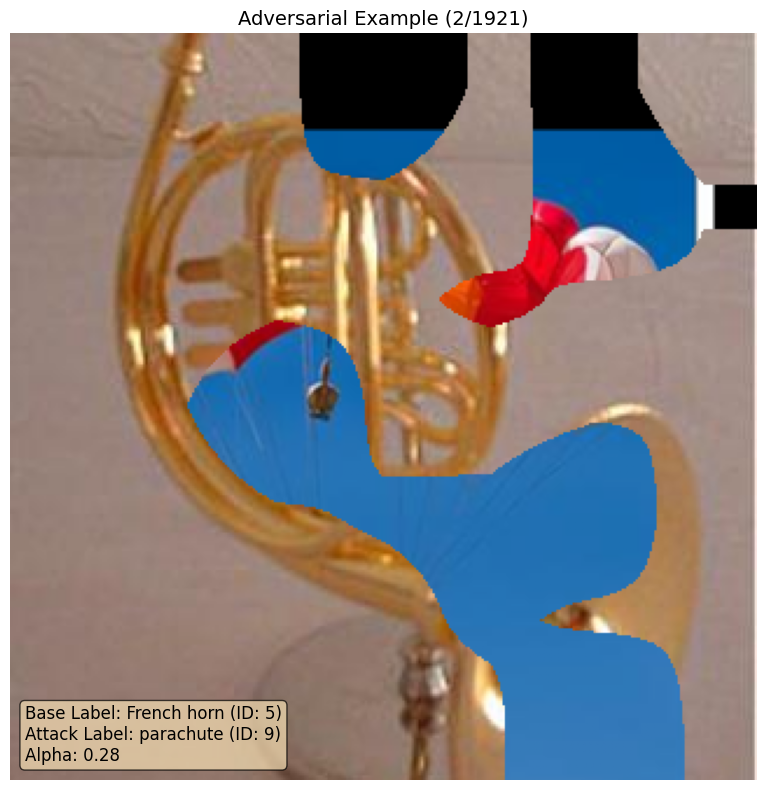

In [22]:
def visualize_adversarial_example(idx, examples, imagenette_labels):
    """
    Visualize an adversarial example with its label information
    
    Args:
        idx: Index of the example to visualize
        examples: List of adversarial examples (image, base_label, attack_label, output_label, threshold)
        imagenette_labels: Dictionary mapping label indices to label names
    """
    if idx >= len(examples):
        print(f"Error: Index {idx} out of range. There are {len(examples)} examples.")
        return
    
    example = examples[idx]
    img = np.moveaxis(example[0], 0, -1)
    base_label = example[1]
    attack_label = example[2]
    output_label = example[3]
    threshold = example[4]
    
    fig, ax = plt.figure(figsize=(10, 8)), plt.gca()
    
    # Display the image
    ax.imshow(img)
    ax.axis('off')
    
    # Create title and text information
    title = f"Adversarial Example ({idx}/{len(examples)-1})"
    info = (
        f"Base Label: {imagenette_labels[base_label]} (ID: {base_label})\n"
        f"Attack Label: {imagenette_labels[attack_label]} (ID: {attack_label})\n"
        f"Alpha: {1-threshold:.2f}"
    )
    
    # Add text box with information
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.02, 0.02, info, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)
    
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return fig

example_idx = 2  
fig = visualize_adversarial_example(example_idx, examples, imagenette_labels)